In [ ]:
import sys
import os

# Add the root directory of your package to the sys.path
sys.path.append(os.path.abspath("C:\\Repos\\yolov3\\classifier"))
sys.path.append(os.path.abspath("C:\\Repos\\yolov3\\yolo"))

Make sure outputs are of expected sizes and no dimensionality errors are present

In [ ]:
import torch
from model import Yolov3

model = Yolov3()
x = torch.randn(1, 3, 416, 416)
y1, y2, y3 = model(x)
assert y1.shape == (1, 85, 3, 52, 52)
assert y2.shape == (1, 85, 3, 26, 26)
assert y3.shape == (1, 85, 3, 13, 13)

print(y1.shape)
print(y2.shape)
print(y3.shape)

x = y1[..., 0]

print(x.shape)

Test to pull images from COCO dataset and draw bounding boxes to ensuring labels are matching.  Also testing to see if transform_targets function is selecting appropriate anchors to be used in the yolo loss fn.

In [ ]:
from coco import COCODataset
from utils import scale_and_normalize_and_augment

PATH = "C:\\Repos\\coco\\coco2017\\train2017\\"
LABELS = "C:\\Repos\\coco\\coco2017\\annotations\\annotations_train.json"

dataset = COCODataset(PATH, LABELS, transform=scale_and_normalize_and_augment)

In [ ]:
import cv2
import numpy
import matplotlib.pyplot as plt
from labels import LABELS
from anchors import ANCHORS
from loss import YOLOv3Loss

tannotation = None

i = 26895
image, tannotation = dataset[i]
ocvImage = cv2.cvtColor(numpy.array(image), cv2.COLOR_RGBA2RGB)

loss = YOLOv3Loss(ANCHORS, 1)

start_point_truth = []
end_point_truth = []
objects_truth = []

start_point_anchor = []
end_point_anchor = []
objects_anchor = []

grids = [416/13, 416/26, 416/52]

for box in tannotation:
    # break if at the end of real boxes, array is filled with zeros after that
    if int(box[0]) == 0 and int(box[1]) == 0 and int(box[2]) == 0 and int(box[3]) == 0 and int(box[4]) == 0:
        break    

    start_point_truth.append((int(box[1]-box[3]), int(box[2]-box[4])))
    end_point_truth.append((int(box[1]+box[3]), int(box[2]+box[4])))
    objects_truth.append(int(box[0]))

    scale, anchor, x, y = int(box[5]), int(box[6]), int(box[7]), int(box[8])

    start_point_anchor.append((int(x * grids[scale] + grids[scale] // 2 - ANCHORS[scale][anchor][0] // 2), 
                               int(y * grids[scale] + grids[scale] // 2 - ANCHORS[scale][anchor][1] // 2)))
    
    end_point_anchor.append((int(x * grids[scale] + grids[scale] // 2 + ANCHORS[scale][anchor][0] // 2), 
                             int(y * grids[scale] + grids[scale] // 2 + ANCHORS[scale][anchor][1] // 2)))

for start, end, obj in zip(start_point_truth, end_point_truth, objects_truth):
    ocvImage = cv2.rectangle(ocvImage, start, end, (0, 255, 0), 2)
    ocvImage = cv2.putText(ocvImage, LABELS[obj], (start[0]+10, end[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 1, cv2.LINE_AA)

#for start, end in zip(start_point_anchor, end_point_anchor):
    #ocvImage = cv2.rectangle(ocvImage, start, end, (0, 255, 255), 2)

plt.imshow(ocvImage)

Passing image through yolo and testing/debugging loss function

In [ ]:
import torch
from model import Yolov3
from anchors import ANCHORS
from coco import COCODataset
from loss import YOLOv3Loss
from utils import scale_and_normalize, scale

PATH = "C:\\coco\\coco2017\\train2017\\"
LABELS = "C:\\coco\\coco2017\\annotations\\annotations_train.json"

dataset_normal = COCODataset(PATH, LABELS, transform=scale_and_normalize)
dataset = COCODataset(PATH, LABELS, transform=scale)

i = 101
image, annotation = dataset[i][0], dataset[i][1]
training = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=False)

images, annotations = next(iter(training))

model = Yolov3()
y1, y2, y3 = model(images)
loss_fn = YOLOv3Loss(ANCHORS)

targets = loss_fn.add_anchors2target(annotations)

loss1, _, _, _ = loss_fn(y1, targets)
loss2, _, _, _ = loss_fn(y2, targets)
loss3, _, _, _ = loss_fn(y3, targets)

loss = loss1 + loss2 + loss3
loss.backward()

Test inital predictions from validation set

Preprocessing time: 0.00
Prediction time: 0.03
NMS time: 0.01
Draw time: 0.00


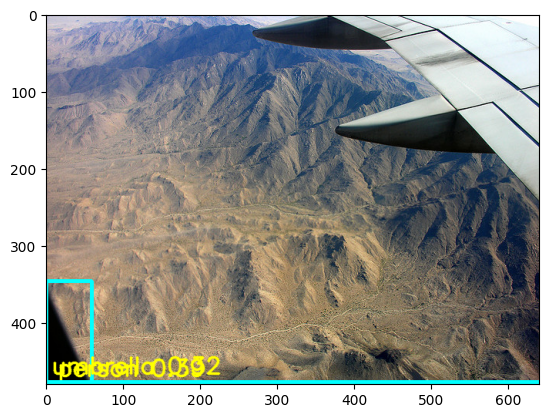

In [10]:
import matplotlib.pyplot as plt
from coco import COCODataset
from yolo import Yolo

PATH = "C:\\Repos\\coco\\coco2017\\val2017\\"
LABELS = "C:\\Repos\\coco\\coco2017\\annotations\\annotations_val.json"

dataset = COCODataset(PATH, LABELS)
yolo = Yolo()

i = 1810
image = dataset[i][0]

image_with_boxes = yolo.run(image)

plt.imshow(image_with_boxes)

Testing some predictions on personal photos

Preprocessing time: 0.15
Prediction time: 0.04
NMS time: 0.02
Draw time: 0.01


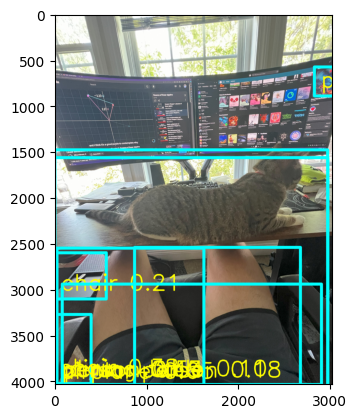

In [3]:
import matplotlib.pyplot as plt
from coco import COCODataset
from yolo import Yolo
from PIL import Image

PATH = "C:\\Repos\\yolov3\\pictures\\IMG_7341.jpg"

yolo = Yolo()

image = Image.open(PATH)

image_with_boxes = yolo.run(image, bb_size=8)

plt.imshow(image_with_boxes)